In [1]:
import tensorflow as tf
# to share the GPU resources for multiple sessions
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

%matplotlib inline

2024-05-10 07:42:46.280417: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 07:42:46.331642: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GRID A100D-40C, pci bus id: 0000:02:02.0, compute capability: 8.0



2024-05-10 07:42:48.469569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 07:42:48.476815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 07:42:48.476979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
my_data_dir = 'dataset/cell_images'

In [4]:
os.listdir(my_data_dir)

['test', 'train']

In [5]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [6]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [7]:
len(os.listdir(train_path+'/uninfected/'))

12479

In [8]:
len(os.listdir(train_path+'/parasitized/'))

12479

In [9]:
os.listdir(train_path+'/parasitized')[0]

'C182P143NThinF_IMG_20151201_172257_cell_157.png'

In [10]:
para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[0])

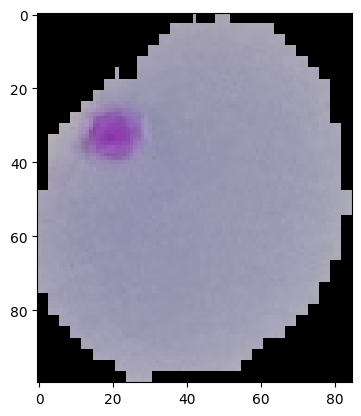

In [11]:
plt.imshow(para_img)

In [12]:
dim1=[]
dim2=[]
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)


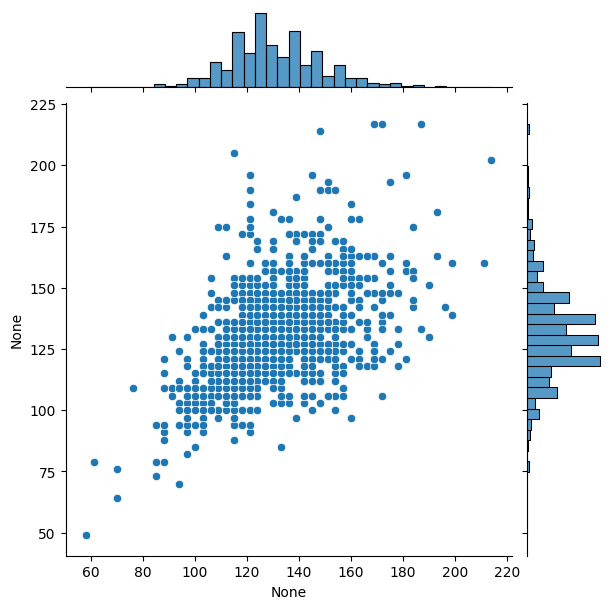

In [13]:
sns.jointplot(x=dim1,y=dim2)

In [14]:
image_shape = (130,130,3)

In [15]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more infor

In [16]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [17]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [18]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [19]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))


model.add(layers.Dense(64))
model.add(layers.Activation('relu'))

model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2024-05-10 07:43:00.562420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 07:43:00.562678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 07:43:00.562775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        51232     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 16)        0

In [21]:
batch_size = 16

In [22]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [23]:
train_image_gen.batch_size

16

In [24]:
len(train_image_gen.classes)

24958

In [25]:
train_image_gen.total_batches_seen

0

In [26]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [27]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [28]:
results = model.fit(train_image_gen,epochs=2,
                              validation_data=test_image_gen)

Epoch 1/2


2024-05-10 07:43:03.105272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-05-10 07:43:03.360311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-10 07:43:03.413206: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f42b1790e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-10 07:43:03.413245: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GRID A100D-40C, Compute Capability 8.0
2024-05-10 07:43:03.418991: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-10 07:43:03.556029: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1560/1560 [==============================] - 110s 69ms/step - loss: 0.6777 - accuracy: 0.5436 - val_loss: 0.2912 - val_accuracy: 0.8892
Epoch 2/2
1560/1560 [==============================] - 107s 68ms/step - loss: 0.1915 - accuracy: 0.9412 - val_loss: 0.1823 - val_accuracy: 0.9450


In [29]:
model.save('cell_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
losses = pd.DataFrame(model.history.history)

<Axes: >

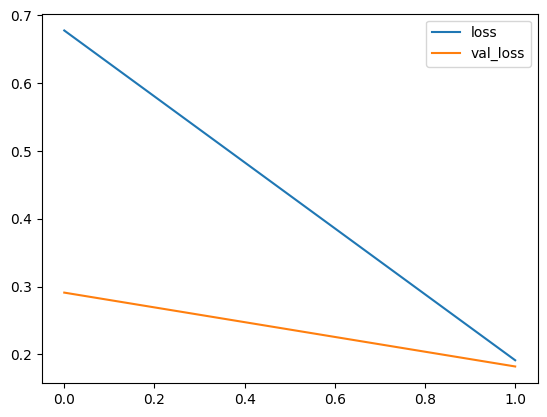

In [31]:
losses[['loss','val_loss']].plot()

In [32]:
model.metrics_names

['loss', 'accuracy']

In [33]:
model.evaluate(test_image_gen)

163/163 [==============================] - 10s 62ms/step - loss: 0.1887 - accuracy: 0.9469


[0.18867221474647522, 0.9469230771064758]

In [34]:
pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 10s 60ms/step


In [35]:

test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [36]:
predictions = pred_probabilities > 0.5

In [37]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1300
           1       0.92      0.96      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [38]:

confusion_matrix(test_image_gen.classes,predictions)

array([[1198,  102],
       [  46, 1254]])

In [39]:
import random
import tensorflow as tf
list_dir=["uninfected"]
dir_=(random.choice(list_dir))
para_img= imread(train_path+
                 '/'+dir_+'/'+
                 os.listdir(train_path+'/'+dir_)[random.randint(0,100)])

In [40]:
img  = tf.convert_to_tensor(np.asarray(para_img))
img = tf.image.resize(img,(130,130))

In [42]:
img=img.numpy()
pred=bool(model.predict(img.reshape(1,130,130,3))<0.5)

1/1 [==============================] - 0s 113ms/step


R.SANJANA
212223240148


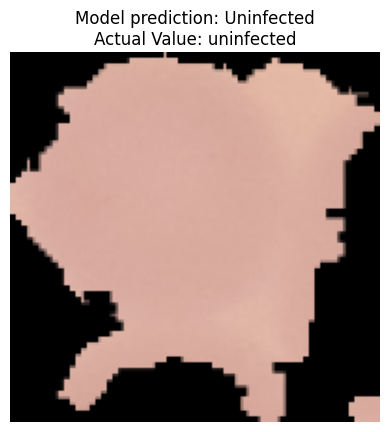

In [43]:
print("R.SANJANA\n212223240148")
plt.title("Model prediction: "+("Parasitized" if pred  else "Uninfected")+"\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)
plt.show()